# Data Discovery Agent
<!-- 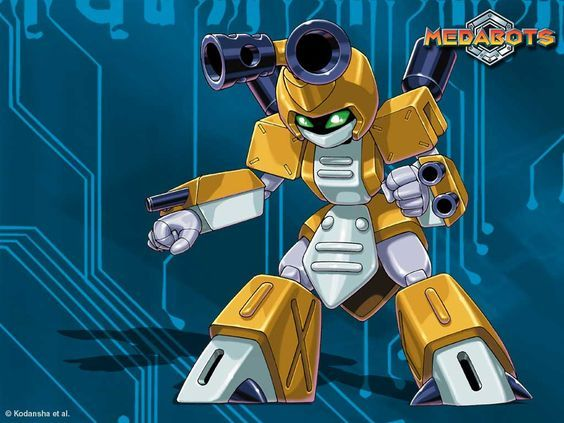

### Data Discovery Agent (Vasco da Gama BOT) -->

**Necessidade**

Na TIM Brail, enfrentamos um desafio significativo na identificação e localização dos ativos de dados espalhados pelo nosso Data Lake, o que dificulta a verificação da disponibilidade desses dados no ambiente produtivo. Com isso surgiu a possibilidade do desenvolvimento de uma solução que guie o usuário no nosso mar de dados.


**Objetivo:**


Ele tem como objetivo descobrir e mapear os dados existentes em diferentes projetos, navegando pelos metadados disponíveis no ambiente BigQuery da TIM Brasil, facilitando o entendimento e o uso eficiente dos dados pelos usuários internos. O agente faz:
- ✅ Realizar buscas inteligentes a partir dos metadados de tabelas e colunas além dos termos de negócio (Business Glossary).
- ⏰ Responder dúvidas específicas dos usuários relacionadas ao contexto dos dados (Data Owner, Data Quality, Consumo, Golden Records).
- ⏰ Assistente de query: Gerar consulta SQL otimizadas tanto para usuários experientes (melhorando e otimizando queries) quanto os usuários que não sabem como construir.
- ⏰ Metadata Writer: Atualizar metadados de tabelas e colunas, garantindo que as informações estejam condizentes e adequadas aos ativos de dados e de acordo com os padrões definidos por Arquitetura.
- ⏰ Data Quality: TBD.

**O que Fizemos?**


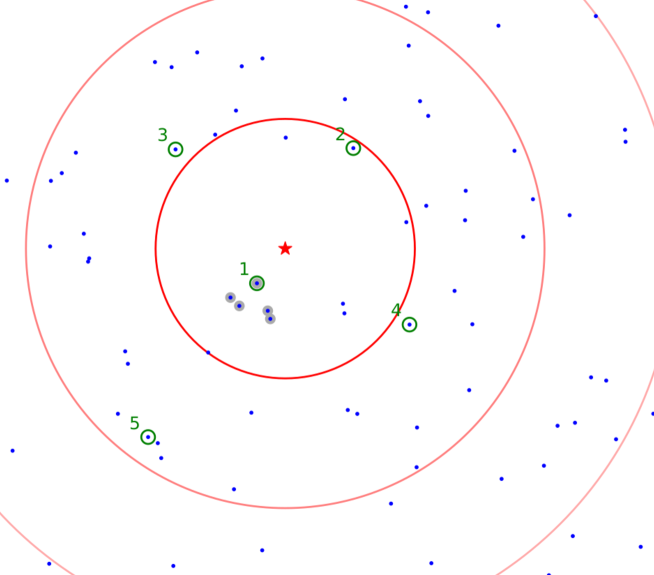


Este agente realiza buscas eficientes nos metadados da empresa, utilizando informações como descrições de colunas, tabelas e termos de negócio presentes no glossário corporativo.​

Para aprimorar a precisão e relevância das respostas, implementamos a estrutura Dartboard, que combina três métodos de ranqueamento distintos:​

1. Similaridade Semântica: Avalia a proximidade de significado entre a consulta do usuário e os documentos disponíveis, empregando modelos de linguagem avançados para compreender o contexto e a intenção por trás das perguntas.​

2. Similaridade Lexical: Analisa a correspondência direta de termos entre a consulta e os documentos, garantindo que palavras-chave específicas sejam consideradas na recuperação das informações.​

3. Importância ou Popularidade *(TODO a ser melhorado com o dados de uso)*: Considera a relevância intrínseca de cada documento, priorizando aqueles que são mais consultados ou possuem maior peso dentro do contexto corporativo.​

Ao integrar esses três métodos, o Dartboard permite que o Metada Bot forneça respostas mais precisas e contextualizadas, melhorando significativamente a experiência do usuário na busca por informações nos metadados da TIM Brasil.

#### Próximos Passos
- Estudar a melhor forma de fazer uma UI para o projeto (Teams, Discord, Whatsapp, Telegram ou Página)
- Estudar o melhor local para hospedar o backend do projeto.
- Refinar o conceito das buscas trazendo:
    - Ranqueamento dos ativos mais utilizados.
    - Ranqueamento dos ativos por particionamento.
    - Golden Records.
    - Tags.
    - Indicadores de Qualidade.

#### Oportunidade Alavancadas com o Agente
- Estruturar melhor os nossos metadados
    - Evolução no preenchimento dos metadados das tabelas mais preenchidas
    - Inclusão dos dados históricos do Glossário de dados (ECQ, ECC e etc)
- Estruturar melhor os termos de negócio
    - Inclusão de termos mais específicos, como Pós, Pré o Controle, assim como Siebel e Clarify (que são sistemas de atendimento)

### Código
##### Criação do arquivo de embeddings

In [14]:
import sys
import csv
import pandas as pd

# Aumenta o limite do tamanho dos campos para evitar o erro
max_int = 2147483647
csv.field_size_limit(max_int)

def generate_text_from_csv(
    columns_csv=r'extract/metadata copy.csv',
    table_metadata_csv=r'extract/table metadata.csv',
    business_glossary_xlsx=r'extract/business_glossary.xlsx',
    output_txt=r'extract/resultados_5.txt'
):
    # Dicionário para agrupar os metadados das colunas por tabela
    table_data = {}

    # Lê o CSV de colunas e agrupa os registros por tabela
    with open(columns_csv, mode='r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            table_id = f"{row['table_catalog']}.{row['table_schema']}.{row['table_name']}"
            if table_id not in table_data:
                table_data[table_id] = {
                    "table_catalog": row["table_catalog"],
                    "table_schema": row["table_schema"],
                    "table_name": row["table_name"],
                    "columns": []
                }
            table_data[table_id]["columns"].append({
                "column_name": row["column_name"],
                "data_type": row["data_type"],
                "description": row["description"]
            })

    # Dicionário para armazenar os metadados das tabelas (descrição)
    table_metadata = {}
    with open(table_metadata_csv, mode='r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['option_name'].strip().lower() == 'description':
                table_id = f"{row['table_catalog']}.{row['table_schema']}.{row['table_name']}"
                table_metadata[table_id] = row['option_value']

    # Lê o glossário de negócios
    df_business_glossary = pd.read_excel(business_glossary_xlsx, header=0, sheet_name='Mapeamento Colunas para Termos')
    df_business_glossary_nna = df_business_glossary.dropna(subset=['Projeto', 'Esquema', 'Nome da Tabela', 'Conceito', 'Definição do Conceito'])
    df_business_glossary_nna['table_id'] = df_business_glossary_nna['Projeto'] + '.' + df_business_glossary_nna['Esquema'] + '.' + df_business_glossary_nna['Nome da Tabela']
    df_business_glossary_final = df_business_glossary_nna.drop_duplicates(subset=['table_id', 'Conceito', 'Definição do Conceito']).reset_index(drop=True)

    business_glossary_dict = {}
    for _, row in df_business_glossary_final.iterrows():
        table_id = row['table_id']
        conceito = row['Conceito']
        definicao = row['Definição do Conceito']
        if table_id not in business_glossary_dict:
            business_glossary_dict[table_id] = []
        business_glossary_dict[table_id].append(f"{conceito} = {definicao}")

    # Gera o texto formatado para cada tabela, mesclando os metadados
    lines = []
    for table_id, info in table_data.items():
        lines.append(f"Tabela: {info['table_catalog']}.{info['table_schema']}.{info['table_name']}")
        if table_id in table_metadata:
            lines.append(f"Descrição da Tabela: {table_metadata[table_id]}")
        if table_id in business_glossary_dict:
            glossario_texto = '; '.join(business_glossary_dict[table_id])
            lines.append(f"Glossário de Negócio: {glossario_texto}")
        lines.append("Colunas:")
        for col in info["columns"]:
            lines.append(f"- {col['column_name']} ({col['data_type']}): {col['description']}")
        lines.append("")  # Linha em branco para separar as tabelas

    # Escreve o resultado em um arquivo de texto
    with open(output_txt, 'w', encoding='utf-8') as txtfile:
        txtfile.write("\n".join(lines))

    print(f"Arquivo de texto salvo em: {output_txt}")
    return table_data, table_metadata, business_glossary_dict


if __name__ == '__main__':
    generate_text_from_csv()


Arquivo de texto salvo em: extract/resultados_5.txt


C:\Users\F8088511\AppData\Local\Temp\ipykernel_31648\245819601.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business_glossary_nna['table_id'] = df_business_glossary_nna['Projeto'] + '.' + df_business_glossary_nna['Esquema'] + '.' + df_business_glossary_nna['Nome da Tabela']


##### Código do RAG com Reinforced Information Gain

In [ ]:
import os
import time
from typing import List, Dict, Any, Tuple
import json
import csv
import pandas as pd
import anthropic
import faiss
import numpy as np
import PyPDF2
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

PORTUGUESE_STOPWORDS = [
    # Artigos
    "a", "à", "ao", "aos", "aquela", "aquelas", "aquele", "aqueles", "as", "às", "da", "das", "de", "dela", 
    "delas", "dele", "deles", "do", "dos", "duas", "esta", "estas", "este", "estes", "esta", "está", "estás", 
    "o", "os", "um", "uma", "umas", "uns",
    
    # Preposições/contrações
    "com", "como", "contra", "desde", "em", "entre", "para", "perante", "por", "sem", "sob", "sobre", "trás",
    "pela", "pelas", "pelo", "pelos", "num", "numa", "nuns", "numas", "dum", "duma", "duns", "dumas",
    
    # Pronomes
    "ele", "eles", "eu", "lhe", "lhes", "me", "meu", "meus", "minha", "minhas", "nós", "se", "seu", "seus", 
    "sua", "suas", "te", "tu", "tua", "tuas", "você", "vocês", "vos",
    
    # Conjunções
    "e", "mas", "nem", "ou", "porém", "que", "quer", "se", "então", "todavia",
    
    # Advérbios/interjeições
    "agora", "aí", "ainda", "ali", "amanhã", "antes", "aqui", "assim", "bem", "cedo", "depois", "hoje", 
    "logo", "mais", "mal", "melhor", "menos", "muito", "não", "onde", "ontem", "pra", "qual", "quando", 
    "quanto", "quê", "sim", "talvez", "tão", "tarde", "tem", "têm", "sim", "já", "só", "talvez",
    
    # Outros
    "etc", "exemplo", "isso", "isto", "outro", "outros", "qualquer", "seja", "também", "outra", "ser", "há",
    "outras", "tempo", "vez", "vezes", "via"
]

def _normalize_embeddings(embeddings: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    norms[norms == 0] = 1
    return embeddings / norms

class ClaudeDocumentProcessor:
    def __init__(self, api_key=None, model="claude-3-7-sonnet-20250219"):
        self.api_key = api_key or os.getenv("ANTHROPIC_API_KEY")
        if not self.api_key:
            raise ValueError("API key não fornecida. Configure a variável de ambiente ANTHROPIC_API_KEY ou passe a chave como parâmetro.")
        
        self.model = model
        self.client = anthropic.Anthropic(api_key=self.api_key)
        
        print("Carregando modelo de embeddings...")
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.dimension = self.embedding_model.get_sentence_embedding_dimension()
        
        self.index = faiss.IndexFlatIP(self.dimension)
        self.document_chunks = []
        self.document_embeddings = None
        self.tfidf_vectorizer = None
        self.tfidf_matrix = None
        self.chunk_size = 2000

        # Parâmetros Dartboard
        self.alpha = 0.7  # Peso para embeddings semânticos
        self.beta = 0.2   # Peso para similaridade lexical
        self.gamma = 0.1  # Peso para popularidade/importância

    def extract_text_from_pdf(self, pdf_path: str) -> str:
        print(f"Extraindo texto de {pdf_path} (PDF)...")
        try:
            with open(pdf_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                text = ""
                for page in reader.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n\n"
                return text
        except Exception as e:
            print(f"Erro ao processar o PDF: {e}")
            return ""
    
    def extract_text_from_txt(self, txt_path: str) -> str:
        print(f"Extraindo texto de {txt_path} (TXT)...")
        try:
            with open(txt_path, 'r', encoding="utf-8") as file:
                text = file.read()
            return text
        except Exception as e:
            print(f"Erro ao processar o arquivo TXT: {e}")
            return ""
    
    def extract_chunks_from_preformatted_txt(self, txt_path: str) -> List[str]:
        print(f"Lendo chunks pré-formatados de {txt_path}...")
        try:
            with open(txt_path, 'r', encoding="utf-8") as file:
                text = file.read()
            chunks = [chunk.strip() for chunk in text.split("\n\n") if chunk.strip()]
            print(f"Arquivo {txt_path} lido com {len(chunks)} chunk(s).")
            return chunks
        except Exception as e:
            print(f"Erro ao ler o arquivo TXT: {e}")
            return []
    
    def extract_text_from_json(self, json_path: str) -> str:
        print(f"Extraindo texto de {json_path} (JSON)...")
        try:
            with open(json_path, 'r', encoding="utf-8") as file:
                data = json.load(file)
            text = json.dumps(data, indent=4, ensure_ascii=False)
            return text
        except Exception as e:
            print(f"Erro ao processar o arquivo JSON: {e}")
            return ""
    
    def extract_text_from_csv(self, csv_path: str) -> List[str]:
        print(f"Extraindo e agrupando metadados de {csv_path} (CSV)...")
        table_data = {}
        try:
            with open(csv_path, mode='r', encoding='utf-8') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    table_id = f"{row['table_catalog']}.{row['table_schema']}.{row['table_name']}"
                    if table_id not in table_data:
                        table_data[table_id] = {
                            "table_catalog": row["table_catalog"],
                            "table_schema": row["table_schema"],
                            "table_name": row["table_name"],
                            "columns": []
                        }
                    table_data[table_id]["columns"].append({
                        "column_name": row["column_name"],
                        "data_type": row["data_type"],
                        "description": row["description"]
                    })
        except Exception as e:
            print(f"Erro ao processar o CSV: {e}")
            return []

        chunks = []
        for table_id, info in table_data.items():
            lines = []
            lines.append(f"Tabela: {info['table_catalog']}.{info['table_schema']}.{info['table_name']}")
            lines.append("Colunas:")
            for col in info["columns"]:
                lines.append(f"- {col['column_name']} ({col['data_type']}): {col['description']}")
            chunks.append("\n".join(lines))
        print(f"Extração concluída: {len(chunks)} chunk(s) gerado(s).")
        return chunks

    def split_text_into_chunks(self, text: str) -> List[str]:
        words = text.split()
        chunks = []
        current_chunk = []
        current_size = 0
        
        for word in words:
            word_size = len(word) + 1
            if current_size + word_size > self.chunk_size and current_chunk:
                chunks.append(" ".join(current_chunk))
                current_chunk = [word]
                current_size = word_size
            else:
                current_chunk.append(word)
                current_size += word_size
        
        if current_chunk:
            chunks.append(" ".join(current_chunk))
        
        print(f"Texto dividido em {len(chunks)} chunks")
        return chunks
    
    def _generate_embeddings(self, texts: List[str]) -> np.ndarray:
        print(f"Gerando embeddings para {len(texts)} chunk(s)...")
        try:
            embeddings = self.embedding_model.encode(texts, show_progress_bar=True)
            return embeddings
        except Exception as e:
            print(f"Erro ao gerar embeddings: {e}")
            return np.zeros((len(texts), self.dimension), dtype=np.float32)
    
    def _build_lexical_index(self, texts: List[str]) -> None:
        print("Construindo índice lexical (TF-IDF)...")
        self.tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=PORTUGUESE_STOPWORDS)
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(texts)
    
    def _calculate_importance_scores(self, texts: List[str]) -> np.ndarray:
        importance = np.array([len(text.split()) for text in texts])
        if importance.sum() > 0:
            importance = importance / importance.sum()
        return importance
    
    def index_document(self, file_path: str) -> None:
        file_path = file_path.strip()
        if file_path.lower().endswith('.pdf'):
            text = self.extract_text_from_pdf(file_path)
            chunks = self.split_text_into_chunks(text)
        elif file_path.lower().endswith('.json'):
            text = self.extract_text_from_json(file_path)
            chunks = self.split_text_into_chunks(text)
        elif file_path.lower().endswith('.csv'):
            chunks = self.extract_text_from_csv(file_path)
        elif file_path.lower().endswith('.txt'):
            if os.path.basename(file_path) == "resultados_4.txt":
                chunks = self.extract_chunks_from_preformatted_txt(file_path)
            else:
                text = self.extract_text_from_txt(file_path)
                chunks = self.split_text_into_chunks(text)
        else:
            print("Tipo de arquivo não suportado. Utilize PDF, TXT, JSON ou CSV.")
            return
        
        if not chunks:
            print("Não foi possível extrair conteúdo do documento.")
            return
        
        self.document_chunks = chunks
        
        embeddings = self._generate_embeddings(chunks)
        normalized_embeddings = _normalize_embeddings(embeddings)
        self.document_embeddings = normalized_embeddings.copy()
        
        self._build_lexical_index(chunks)
        self.importance_scores = self._calculate_importance_scores(chunks)
        self.index.reset()
        self.index.add(normalized_embeddings.astype(np.float32))
        print(f"Documento indexado com sucesso! {len(chunks)} chunk(s) adicionados ao índice.")
        self._save_state()
    
    def _save_state(self, chunks_filename="document_chunks.json", index_filename="faiss_index.bin", 
                   tfidf_filename="tfidf_model.pkl", importance_filename="importance_scores.npy"):
        try:
            with open(chunks_filename, "w", encoding="utf-8") as f:
                json.dump(self.document_chunks, f, ensure_ascii=False)
            faiss.write_index(self.index, index_filename)
            
            if self.tfidf_vectorizer is not None:
                import pickle
                with open(tfidf_filename, "wb") as f:
                    pickle.dump(self.tfidf_vectorizer, f)
            
            if hasattr(self, 'importance_scores'):
                np.save(importance_filename, self.importance_scores)
                
            print("Estado salvo com sucesso!")
        except Exception as e:
            print(f"Erro ao salvar estado: {e}")
    
    def load_state(self, chunks_filename="document_chunks.json", index_filename="faiss_index.bin",
                   tfidf_filename="tfidf_model.pkl", importance_filename="importance_scores.npy") -> bool:
        try:
            if os.path.exists(chunks_filename):
                with open(chunks_filename, "r", encoding="utf-8") as f:
                    self.document_chunks = json.load(f)
                    
            if os.path.exists(index_filename):
                self.index = faiss.read_index(index_filename)
                
                if self.document_chunks:
                    embeddings = self._generate_embeddings(self.document_chunks)
                    self.document_embeddings = _normalize_embeddings(embeddings)
                    
                    if os.path.exists(tfidf_filename):
                        import pickle
                        with open(tfidf_filename, "rb") as f:
                            self.tfidf_vectorizer = pickle.load(f)
                        self.tfidf_matrix = self.tfidf_vectorizer.transform(self.document_chunks)
                    else:
                        self._build_lexical_index(self.document_chunks)
                        
                    if os.path.exists(importance_filename):
                        self.importance_scores = np.load(importance_filename)
                    else:
                        self.importance_scores = self._calculate_importance_scores(self.document_chunks)
                        
                print(f"Estado carregado com sucesso! {len(self.document_chunks)} chunk(s) disponíveis.")
                return True
            return False
        except Exception as e:
            print(f"Erro ao carregar estado: {e}")
            return False

    def clear_memory(self, chunks_filename="document_chunks.json", index_filename="faiss_index.bin",
                     tfidf_filename="tfidf_model.pkl", importance_filename="importance_scores.npy"):
        self.document_chunks = []
        self.document_embeddings = None
        self.tfidf_vectorizer = None
        self.tfidf_matrix = None
        self.importance_scores = None
        self.index = faiss.IndexFlatIP(self.dimension)
        
        for filename in [chunks_filename, index_filename, tfidf_filename, importance_filename]:
            if os.path.exists(filename):
                os.remove(filename)
                
        print("Memória limpa com sucesso!")
    
    def dartboard_ranking(self, query: str, top_k_initial: int = 30) -> List[Dict[str, Any]]:
        if self.index.ntotal == 0:
            print("Nenhum documento indexado.")
            return []
        
        try:
            query_embedding = self.embedding_model.encode([query])
            normalized_query = _normalize_embeddings(query_embedding)
            distances, indices = self.index.search(normalized_query.astype(np.float32), top_k_initial)
            
            if self.tfidf_vectorizer is not None:
                query_tfidf = self.tfidf_vectorizer.transform([query])
                lexical_scores = np.zeros(len(indices[0]))
                for i, idx in enumerate(indices[0]):
                    lexical_scores[i] = cosine_similarity(
                        query_tfidf, self.tfidf_matrix[idx].reshape(1, -1)
                    ).item()
            else:
                lexical_scores = np.zeros(len(indices[0]))
            
            importance_scores = np.zeros(len(indices[0]))
            if hasattr(self, 'importance_scores'):
                for i, idx in enumerate(indices[0]):
                    importance_scores[i] = self.importance_scores[idx]
            
            combined_scores = (
                self.alpha * distances[0] +
                self.beta * lexical_scores +
                self.gamma * importance_scores
            )
            
            reranked_indices = np.argsort(-combined_scores)
            results = []
            for i in reranked_indices:
                doc_idx = indices[0][i]
                results.append({
                    "chunk_id": int(doc_idx),
                    "score": float(combined_scores[i]),
                    "text": self.document_chunks[doc_idx],
                    "semantic_score": float(distances[0][i]),
                    "lexical_score": float(lexical_scores[i]),
                    "importance_score": float(importance_scores[i])
                })
            
            return results
        except Exception as e:
            print(f"Erro no ranking Dartboard: {e}")
            return []
    
    def _filter_diverse_results(self, results: List[Dict[str, Any]], diversity_threshold: float = 0.95) -> List[Dict[str, Any]]:
        selected = []
        selected_ids = []
        
        for result in results:
            chunk_id = result["chunk_id"]
            candidate_embedding = self.document_embeddings[chunk_id]
            is_redundant = False
            for s in selected_ids:
                sim = np.dot(candidate_embedding, self.document_embeddings[s])
                if sim > diversity_threshold:
                    is_redundant = True
                    break
            if not is_redundant:
                selected.append(result)
                selected_ids.append(chunk_id)
        return selected

    def query_document(self, query: str, top_k: int = 3) -> List[Dict[str, Any]]:
        if self.index.ntotal == 0:
            print("Nenhum documento indexado ainda.")
            return []
            
        try:
            retrieval_k = max(top_k * 3, 30)
            initial_results = self.dartboard_ranking(query, retrieval_k)
            diverse_results = self._filter_diverse_results(initial_results, diversity_threshold=0.95)
            if len(diverse_results) > top_k:
                diverse_results = diverse_results[:top_k]
            return diverse_results
        except Exception as e:
            print(f"Erro ao consultar documento: {e}")
            return []
    
    def ask_claude_with_context(self, query: str, top_k: int = 3) -> str:
        relevant_chunks = self.query_document(query, top_k)
        if not relevant_chunks:
            return "Não há documentos indexados para responder esta pergunta."
        
        context_chunks = []
        for i, chunk in enumerate(relevant_chunks):
            context_chunks.append(f"[Documento {i+1} - Score Dartboard: {chunk['score']:.4f}]\n{chunk['text']}")
        context = "\n\n".join(context_chunks)

        df_business_glossary = pd.read_excel(r'extract/business_glossary.xlsx', header=0, sheet_name='Mapeamento Colunas para Termos')
        df_business_glossary_nna = df_business_glossary.dropna(subset=['Conceito', 'Definição do Conceito'])[['Conceito', 'Definição do Conceito']]#'Termo De Negócio', 'Definição do Termo de Negócio'])[['Termo De Negócio', 'Definição do Termo de Negócio']]
        df_business_glossary_final = df_business_glossary_nna.drop_duplicates().reset_index(drop=True)
        business_glossary_text = ""
        for _, row in df_business_glossary_final.iterrows():
            business_glossary_text += f"O termo {row['Conceito']} refere-se a {row['Definição do Conceito']}\n"

        messages = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"""
                        Você é um Assistente AI chamado GePeTo especializado em analise de dados para uma empresa de telecomunicações Brasileira.
                        Sua tarefa é responder perguntas baseadas em um contexto de dados enviado. 
                        Aqui estão os Contextos e a Pertunta em si: 
                        
                        <context>
                        {context}
                        </context>

                        <query>
                        {query}
                        </query>

                        ---
                        Siga as seguintes regras:
                        1. Responda de forma clara e concisa.
                        2. Reporte apenas tabelas do projeto tim-bigdata-prod-e305.
                        3. Preferencialmente no dataset "trusted_*" ou "curated_*".
                        4. Todas as perguntas são referentes ao contexto de analise de dados em uma empresa de telecomunicações Brasileira.
                        5. Responda as perguntas utilizando somente as informações do Contexto.
                        6. Traga a seguinte extrutura
                        - projeto.dataset.tabela 
                            - Breve descrição da tabela com bases nas descrições das colunas.
                            - O que essa tabela tem de informação para que seja considerada como resposta da query.
                        7. Caso não encontre nada no contexto, diga que não há registro suficientes de metadados para a informação que está sendo procurada.

                        ---
                        Leve em consideração alguns aspectos:
                        1. ECQ = Excellence Consistant Quality = Mede a qualidade do sinal em algum ponto.
                        2. ECC = Excellence Coverage Consistant = Mede a consistencia da cobertura de rede.
                        <scratchpad>
                        [Use esse espaço para analisar o contexto, identificando tabelas ou views relevantes e estruture a resposta]
                        </scratchpad>

                        Agora, entregue sua resposta final dentro da tag <answer>. Inclua informações relevantes da tabela, como especificado na regra 6, ou retorne, caso tenha dados insuficientes para responder a query.

                        <answer>
                        """
                    }
                ]
            }
        ]
        try:
            response = self.client.messages.create(
                model=self.model,
                max_tokens=5000,
                temperature=0,
                messages=messages
            )
            return response.content[0].text
        except Exception as e:
            return f"Erro ao consultar o Claude: {e}"
    
    def adjust_dartboard_weights(self, alpha: float = None, beta: float = None, gamma: float = None):
        if alpha is not None:
            self.alpha = alpha
        if beta is not None:
            self.beta = beta
        if gamma is not None:
            self.gamma = gamma
        print(f"Pesos Dartboard ajustados: alpha={self.alpha}, beta={self.beta}, gamma={self.gamma}")
    
    def evaluate_retrieval(self, query: str, k_values: List[int] = [1, 3, 5, 10]):
        print(f"Avaliando recuperação para query: '{query}'")
        dartboard_results = self.query_document(query, max(k_values))
        
        query_embedding = self.embedding_model.encode([query])
        normalized_query = _normalize_embeddings(query_embedding)
        distances, indices = self.index.search(normalized_query.astype(np.float32), max(k_values))
        
        embedding_results = []
        for i, idx in enumerate(indices[0][:max(k_values)]):
            embedding_results.append({
                "chunk_id": int(idx),
                "score": float(distances[0][i]),
                "text": self.document_chunks[idx]
            })
        
        print("\n=== COMPARAÇÃO DE MÉTODOS DE RECUPERAÇÃO ===")
        for k in k_values:
            print(f"\n--- Top {k} resultados ---")
            print("\n>> Dartboard:")
            for i, res in enumerate(dartboard_results[:k]):
                print(f"{i+1}. [Score: {res['score']:.4f}] {res['text'][:100]}...")
            print("\n>> Apenas Embeddings:")
            for i, res in enumerate(embedding_results[:k]):
                print(f"{i+1}. [Score: {res['score']:.4f}] {res['text'][:100]}...")
        
        return {
            "dartboard": dartboard_results,
            "embeddings": embedding_results
        }

def parse_top_k(input_str: str) -> int:
    digits = ''.join(ch for ch in input_str if ch.isdigit())
    if digits:
        return int(digits)
    else:
        return 50

def run_interactive():
    print("Iniciando processador de documentos com Dartboard (PDF, TXT, JSON e CSV)...")
    processor = ClaudeDocumentProcessor()
    
    processor.load_state()
    
    while True:
        if processor.index.ntotal == 0:
            print("Nenhum documento indexado. Por favor, indexe um arquivo primeiro.")
            continue
        query = input("Digite sua pergunta para o Claude: ").strip()
        top_input = input("Quantos chunks usar como contexto (ex: 'top2', 'top 50', '3')? ").strip()
        top_k = parse_top_k(top_input)
        answer = processor.ask_claude_with_context(query, top_k)
        print(f'\nA pergunta solicitada foi: {query}')
        print("\nResposta do Claude:")
        print(answer)
        
        print("\nMenu:")
        print("1 - Indexar documento (PDF, TXT, JSON ou CSV)")
        print("2 - Consultar documento com Dartboard (query)")
        print("3 - Perguntar ao Claude com contexto Dartboard")
        print("4 - Limpar memória")
        print("5 - Ajustar pesos do Dartboard")
        print("6 - Avaliar recuperação (comparar métodos)")
        print("0 - Sair")
        
        opcao = input("Escolha uma opção: ").strip()
        
        if opcao == "1":
            file_path = input("Digite o caminho para o arquivo (PDF, TXT, JSON ou CSV): ").strip()
            if os.path.exists(file_path):
                processor.index_document(file_path)
            else:
                print("Arquivo não encontrado. Verifique o caminho informado.")
        elif opcao == "2":
            if processor.index.ntotal == 0:
                print("Nenhum documento indexado. Por favor, indexe um arquivo primeiro.")
                continue
            query = input("Digite sua consulta: ").strip()
            top_input = input("Quantos resultados deseja (ex: 'top2', 'top 50', '3')? ").strip()
            top_k = parse_top_k(top_input)
            results = processor.query_document(query, top_k)
            if results:
                print(f"\nResultados para: '{query}'")
                for i, result in enumerate(results):
                    print(f"\n--- Resultado {i+1} (Score Dartboard: {result['score']:.4f}) ---")
                    print(f"Score semântico: {result['semantic_score']:.4f}, Léxico: {result['lexical_score']:.4f}, Importância: {result['importance_score']:.4f}")
                    print(result['text'] if len(result['text']) < 500 else result['text'][:500] + "...")
            else:
                print("Nenhum resultado encontrado.")
        elif opcao == "3":
            if processor.index.ntotal == 0:
                print("Nenhum documento indexado. Por favor, indexe um arquivo primeiro.")
                continue
            query = input("Digite sua pergunta para o Claude: ").strip()
            top_input = input("Quantos chunks usar como contexto (ex: 'top2', 'top 50', '3')? ").strip()
            top_k = parse_top_k(top_input)
            answer = processor.ask_claude_with_context(query, top_k)
            print(f'\nA pergunta solicitada foi: {query}')
            print("\nResposta do Claude:")
            print(answer)
        elif opcao == "4":
            processor.clear_memory()
        elif opcao == "5":
            print(f"Pesos atuais: alpha={processor.alpha} (semântico), beta={processor.beta} (léxico), gamma={processor.gamma} (importância)")
            try:
                alpha = float(input("Novo valor para alpha (semântico) [0-1]: ").strip() or str(processor.alpha))
                beta = float(input("Novo valor para beta (léxico) [0-1]: ").strip() or str(processor.beta))
                gamma = float(input("Novo valor para gamma (importância) [0-1]: ").strip() or str(processor.gamma))
                total = alpha + beta + gamma
                if total > 0:
                    alpha /= total
                    beta /= total
                    gamma /= total
                processor.adjust_dartboard_weights(alpha, beta, gamma)
            except ValueError:
                print("Valores inválidos. Os pesos devem ser números.")
        elif opcao == "6":
            if processor.index.ntotal == 0:
                print("Nenhum documento indexado. Por favor, indexe um arquivo primeiro.")
                continue
            query = input("Digite sua consulta para avaliação: ").strip()
            processor.evaluate_retrieval(query, [1, 3, 5])
        elif opcao == "0":
            print("Encerrando...")
            break
        else:
            print("Opção inválida. Tente novamente.")

if __name__ == "__main__":
    run_interactive()


c:\Users\F8088511\AppData\Local\anaconda3\envs\gemini-local\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
processor = ClaudeDocumentProcessor()

processor.load_state()


Carregando modelo de embeddings...
Gerando embeddings para 4580 chunk(s)...


Batches: 100%|██████████| 144/144 [10:48<00:00,  4.50s/it]


Estado carregado com sucesso! 4580 chunk(s) disponíveis.


True

In [2]:
run_interactive()

Iniciando processador de documentos com Dartboard (PDF, TXT, JSON e CSV)...
Carregando modelo de embeddings...
Gerando embeddings para 4580 chunk(s)...


Batches: 100%|██████████| 144/144 [02:37<00:00,  1.09s/it]


Estado carregado com sucesso! 4580 chunk(s) disponíveis.

A pergunta solicitada foi: 

Resposta do Claude:
<answer>
Analisando o contexto fornecido, não encontrei uma query específica para responder. No entanto, posso listar as tabelas relevantes do projeto tim-bigdata-prod-e305 que foram mencionadas no contexto e que poderiam ser úteis para análises de dados em uma empresa de telecomunicações brasileira:

- tim-bigdata-prod-e305.raw_googleads.p_ads_campaignlocationtargetstats_9976812721
  - Contém métricas de campanhas publicitárias por localização, incluindo cliques, conversões, custo por impressão (CPM), taxa de engajamento.
  - Útil para análise de desempenho de campanhas publicitárias por região geográfica.

- tim-bigdata-prod-e305.raw_googleads.p_ads_video_1184175593
  - Armazena informações sobre vídeos publicitários, incluindo título, duração e status.
  - Permite análise de campanhas de vídeo e seu desempenho.

- tim-bigdata-prod-e305.raw_whatsapp.tb_raw_whatsapp_adcc
  - Cont

### Pergunta 1 : Quero dados de consumo do cliente. Apenas com trafego em 5g e o número do cliente
Cenário onde o cliente está pedindo uma base de dados mais genéricas e que é preciso validar parte das colunas

In [7]:
run_interactive()

Iniciando processador de documentos com Dartboard (PDF, TXT, JSON e CSV)...

Menu:
1 - Indexar documento (PDF, TXT, JSON ou CSV)
2 - Consultar documento com Dartboard (query)
3 - Perguntar ao Claude com contexto Dartboard
4 - Limpar memória
5 - Ajustar pesos do Dartboard
6 - Avaliar recuperação (comparar métodos)
0 - Sair
O termo Ciclo de Faturamento  refere-se a  Ciclo de Faturamento é o termo utilizado para identidicar um cilo completo de faturamento com base nas informações da fatura e suas especificações.
O termo Identificação de Cliente refere-se a Identificação de Cliente é o termo usado para definir informações que são usadas para identificar o Cliente.
O termo Identificação de Cliente  refere-se a Identificação de Cliente é o termo usado para definir informações que são usadas para identificar o Cliente.
O termo Endereço de Cliente refere-se a Endereço de Cliente  é o termo usado para identificar informações de localização do Cliente.
O termo Tipo de Contrato refere-se a Tipo d

#### Pergunta 2.  Quero saber dados de consumo por franquia ou rating group
Nessa pergunta foi procurado ser o mais específico possível, pedindo dados de franquia dos usuários. Nesse contexto, apenas uma tabela deverá ser reportada.

In [18]:
run_interactive()

Iniciando processador de documentos com Dartboard (PDF, TXT, JSON e CSV)...
Carregando modelo de embeddings...

Menu:
1 - Indexar documento (PDF, TXT, JSON ou CSV)
2 - Consultar documento com Dartboard (query)
3 - Perguntar ao Claude com contexto Dartboard
4 - Limpar memória
5 - Ajustar pesos do Dartboard
6 - Avaliar recuperação (comparar métodos)
0 - Sair
Nenhum documento indexado. Por favor, indexe um arquivo primeiro.

Menu:
1 - Indexar documento (PDF, TXT, JSON ou CSV)
2 - Consultar documento com Dartboard (query)
3 - Perguntar ao Claude com contexto Dartboard
4 - Limpar memória
5 - Ajustar pesos do Dartboard
6 - Avaliar recuperação (comparar métodos)
0 - Sair
Nenhum documento indexado. Por favor, indexe um arquivo primeiro.

Menu:
1 - Indexar documento (PDF, TXT, JSON ou CSV)
2 - Consultar documento com Dartboard (query)
3 - Perguntar ao Claude com contexto Dartboard
4 - Limpar memória
5 - Ajustar pesos do Dartboard
6 - Avaliar recuperação (comparar métodos)
0 - Sair
Extraindo tex

Batches: 100%|██████████| 144/144 [02:59<00:00,  1.25s/it]


Construindo índice lexical (TF-IDF)...
Documento indexado com sucesso! 4580 chunk(s) adicionados ao índice.
Estado salvo com sucesso!

Menu:
1 - Indexar documento (PDF, TXT, JSON ou CSV)
2 - Consultar documento com Dartboard (query)
3 - Perguntar ao Claude com contexto Dartboard
4 - Limpar memória
5 - Ajustar pesos do Dartboard
6 - Avaliar recuperação (comparar métodos)
0 - Sair

A pergunta solicitada foi: Quero saber dados de consumo por franquia ou rating group

Resposta do Claude:
<answer>
Com base nos metadados disponíveis no contexto, encontrei a seguinte tabela que contém informações sobre consumo por franquia ou rating group:

- tim-bigdata-prod-e305.trusted_ctp.dw_r_ctp_rg_hora
    - Descrição: A tabela armazena informações agrupadas sobre o tráfego de dados e eventos na rede TIM, categorizadas por grupos de tarifação (rating group) e organizadas em intervalos horários. Os dados abrangem eventos relacionados a chamadas, uso de dados, localização geográfica, dispositivos e métri

#### Pergunta 3: Estou procurando sobre dados detalhados da fatura do cliente
Nesse cenário, o Bot trouxe as duas principais tabelas ```tim-bigdata-prod-e305.fact.dw_f_fat_fatura``` e ```tim-bigdata-prod-e305.fact.dw_f_fat_item_fatura``` que abordam sobre fatura. Porém ele trouxe informações adicionais incoerentes. Acredito que adicionando o Ranqueamento por acesso, conseguimos evitar a inclusão de informações desnecessárias.

In [21]:
run_interactive()

Iniciando processador de documentos com Dartboard (PDF, TXT, JSON e CSV)...
Carregando modelo de embeddings...
Gerando embeddings para 4580 chunk(s)...


Batches: 100%|██████████| 144/144 [02:58<00:00,  1.24s/it]


Estado carregado com sucesso! 4580 chunk(s) disponíveis.

Menu:
1 - Indexar documento (PDF, TXT, JSON ou CSV)
2 - Consultar documento com Dartboard (query)
3 - Perguntar ao Claude com contexto Dartboard
4 - Limpar memória
5 - Ajustar pesos do Dartboard
6 - Avaliar recuperação (comparar métodos)
0 - Sair

A pergunta solicitada foi: Estou procurando sobre dados detalhados da fatura do cliente

Resposta do Claude:
<answer>
# Dados detalhados da fatura do cliente

Com base no contexto fornecido, encontrei várias tabelas que contêm informações detalhadas sobre faturas de clientes. Aqui estão as principais:

## 1. tim-bigdata-prod-e305.fact.dw_f_fat_fatura
- **Descrição**: Esta tabela contém informações completas sobre as faturas dos clientes, incluindo dados cadastrais, valores, datas de vencimento, métodos de pagamento, e detalhes fiscais.
- **Relevância**: Possui informações essenciais como valor total da fatura, data de vencimento, código de barras para pagamento, CPF/CNPJ do cliente, in

#### Pergunta 4: Me traga dados do sieble para clientes pos
Nessa pergunta, o usuário foi genérico e perguntou apenas onde seria possível encontrar os dados de atendimento para clientes pós.
O Bot errou ao apontar as tabelas, o certo seria trazer a ```tim-bigdata-prod-e305.fact.dw_f_atnd_siebel_pos_os``` como resultado.

In [20]:
run_interactive()

Iniciando processador de documentos com Dartboard (PDF, TXT, JSON e CSV)...
Carregando modelo de embeddings...
Gerando embeddings para 4580 chunk(s)...


Batches: 100%|██████████| 144/144 [02:48<00:00,  1.17s/it]


Estado carregado com sucesso! 4580 chunk(s) disponíveis.

Menu:
1 - Indexar documento (PDF, TXT, JSON ou CSV)
2 - Consultar documento com Dartboard (query)
3 - Perguntar ao Claude com contexto Dartboard
4 - Limpar memória
5 - Ajustar pesos do Dartboard
6 - Avaliar recuperação (comparar métodos)
0 - Sair

A pergunta solicitada foi: Me traga dados do sieble para clientes pos

Resposta do Claude:
<answer>
Com base no contexto fornecido, encontrei algumas tabelas no Siebel com dados relevantes para clientes pós-pago:

1. tim-bigdata-prod-e305.aux.dw_d_p609_siebel_bat222
   - Descrição: Base detalhada de dados contratuais de clientes, com informações cadastrais, demográficas, contato, documentos e dados empresariais. Contém detalhes como nome completo, e-mail, telefone, endereço, documentos e dados de renda dos clientes.
   - Relevância: Esta tabela é específica do Siebel e contém informações completas de cadastro para clientes, incluindo perfil demográfico, comportamento de consumo e carac

### Pergunta Customizada

In [9]:
run_interactive()

Iniciando processador de documentos com Dartboard (PDF, TXT, JSON e CSV)...
Carregando modelo de embeddings...
Gerando embeddings para 4580 chunk(s)...


Batches: 100%|██████████| 144/144 [04:18<00:00,  1.79s/it]


Estado carregado com sucesso! 4580 chunk(s) disponíveis.

A pergunta solicitada foi: estou precisando de uma base que mostre o churn voluntário (exceto migração)  por cliente. Vocês saberiam qual base posso usar? Se tiver motivo de churn, seria bom tbm

Resposta do Claude:
<answer>
Para informações sobre churn voluntário por cliente, incluindo motivos de churn, recomendo as seguintes tabelas:

1. tim-bigdata-prod-e305.curated_cda.vw_relt_churn
   - Descrição: View que consolida e categoriza os motivos e tipos de churn dos clientes TIM para os segmentos pré-pago, pós-pago e ultrafibra, proporcionando insights sobre os padrões de cancelamento.
   - Esta view contém as seguintes informações relevantes:
     * cd_contrato (STRING): Código do Contrato do cliente
     * dt_churn (DATE): Data de realização do churn do cliente
     * ds_motivo_churn (STRING): Motivo do churn
     * tp_churn (STRING): Tipo de churn (ex: cancelamento, não renovação)
     * cd_timid (STRING): Código TIM ID do Cli

---
### Prompt Library

**Objetivo**

O objetivo desse projeto é disponibilizar uma biblioteca centralizada com prompts pré-configurados que as equipes possam utilizar para agilizar e padronizar suas atividades diárias. Servindo inclusive como priorização do desenvolvimento dos agentes com os prompts mais utilziados pelos times.

**O que Fizemos?**

Criamos uma **Prompt Library** que atualmente está disponível em uma lista no SharePoint, contemplando inicialmente as principais atividades do time de Data Governance. Os prompts são aplicáveis a múltiplos cenários, incluindo PySpark, Python e SQL, cobrindo atividades como:

- **Documentação **do** código com normas de qualidade:** Implementamos padrões que garantem clareza, facilidade de manutenção e colaboração eficaz entre equipes.

- **Criação de diagramas de fluxo das atividades dos códigos:** Disponibilizamos templates que permitem representar visualmente as lógicas implementadas, facilitando revisões e melhorias nos processos.

- **Documentação **de** código seguindo normas internacionais:** Definimos orientações alinhadas a padrões globais, permitindo maior integração em projetos internacionais e garantindo excelência técnica nas entregas.

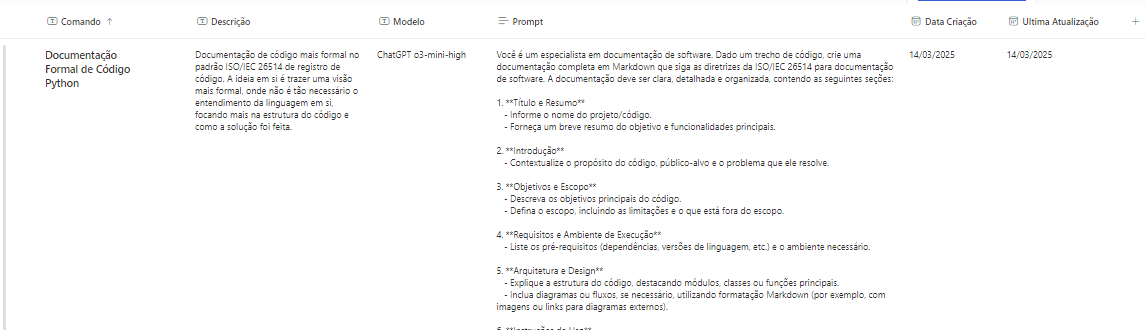

[Prompt Library](https://timbrasil.sharepoint.com/teams/TIM_22aa27315b8043d7865bf222ad136d85/Lists/Prompt%20Library/AllItems.aspx?sortField=LinkTitle&isAscending=true&viewid=4346ac2d%2D02ac%2D466a%2D9140%2D959f91d573f3&npsAction=createList)


#### Próximos Passos

Para evoluir com a **Prompt Library**, precisamos:

- **Definir o Formato Ideal:** Avaliar qual formato é mais eficiente para disponibilizar os prompts, considerando facilidade de acesso e usabilidade pelas equipes.

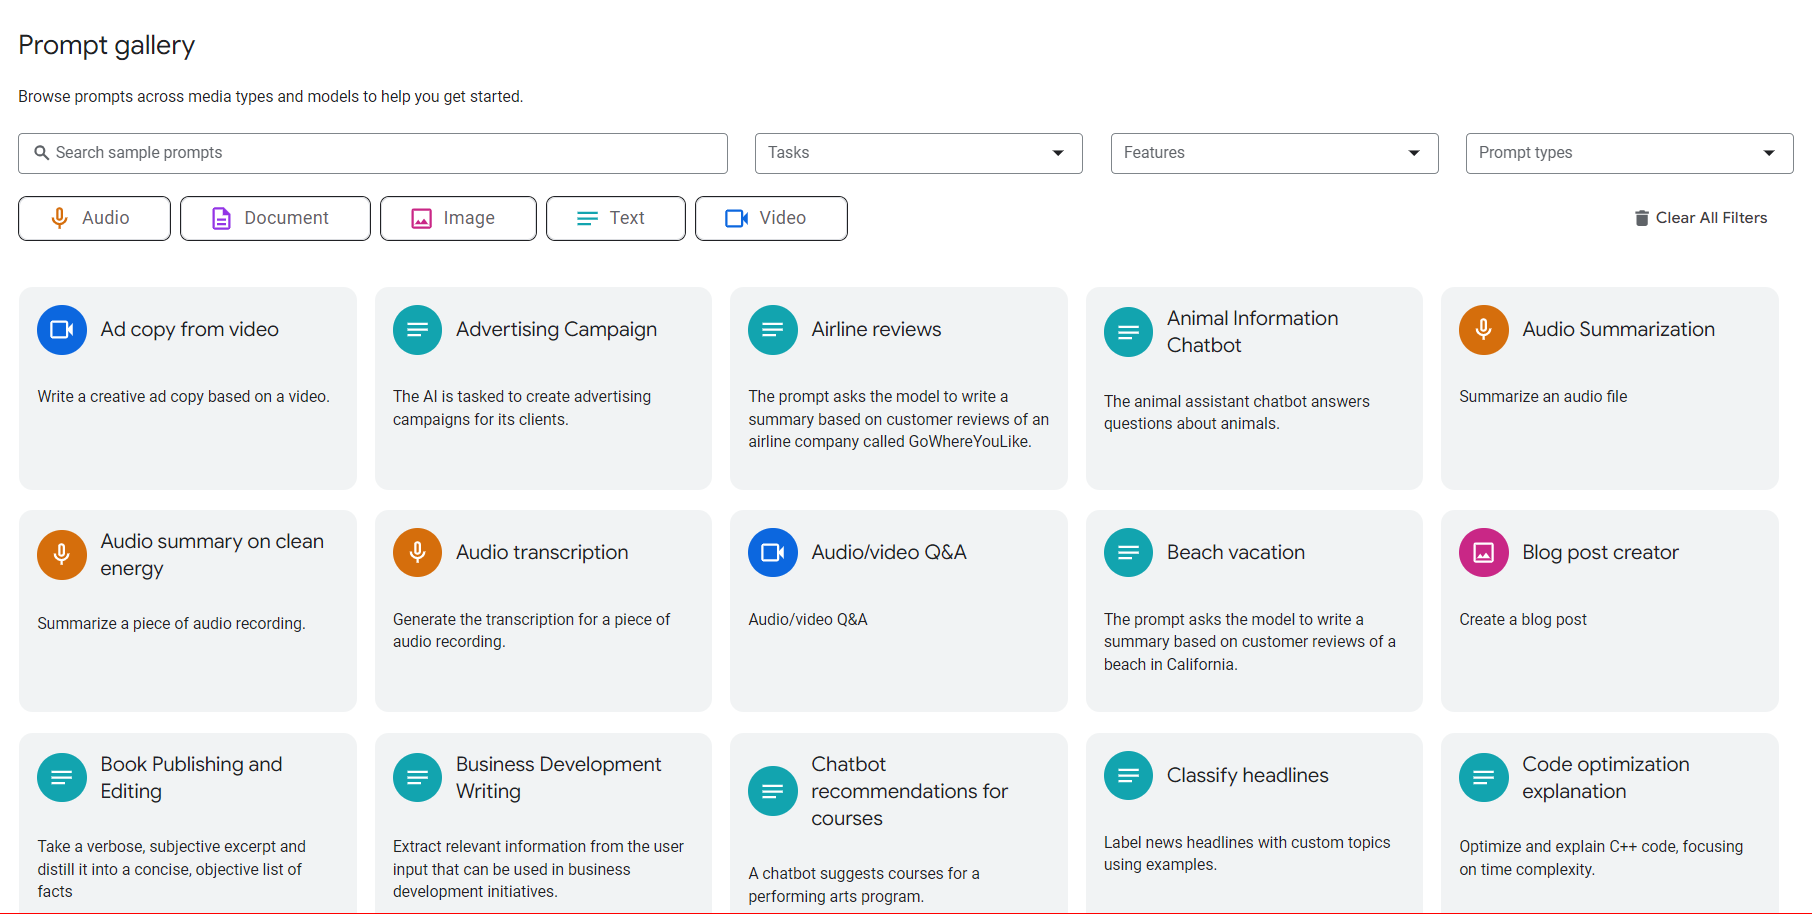

- **Integração com Vertex AI:** Implementar os prompts diretamente no Vertex AI para uso simplificado e otimizado pelo nosso time interno.

- **Avaliação do uso do DocGen:** Analisar a possibilidade de utilizar (ou adaptar) a framework do DocGen, desenvolvida pelo time do Jone, para disponibilizar os prompts para times externos.

- **Integração Front/Backend semelhante ao Medabot:** Aplicar a mesma arquitetura técnica de front/backend utilizada pelo Medabot, garantindo uma experiência consistente e robusta na utilização dos prompts.
